In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from tqdm import tqdm

import pyroomacoustics as pra
import itertools

from pathlib import Path

import shamans.utils.eval_utils as eval

Used the data of experiment 3, but use threshold to find the number of sources.

In [2]:
# merge all the csv fo the experiments 1 for different runs
def merge_csvs_and_get_dataframe(exp_id, path_to_results):
    all_filenames = [i for i in path_to_results.glob(f'*_exp-{exp_id}_run-*.csv')]
    combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames])
    combined_csv.to_csv(path_to_results / f"experiment_results_exp-{exp_id}_all_runs.csv", index=False, encoding='utf-8-sig')
    return combined_csv

def merge_pickles_and_get_dict(exp_id, path_to_results):
    all_filenames = [i for i in path_to_results.glob(f'*_exp-{exp_id}_run-*_with_ang_specs.pkl')]
    combined_dicts = []
    for filename in tqdm(all_filenames):
        with open(filename, 'rb') as f:
            combined_dicts += pickle.load(f)
    with open(path_to_results / f"experiment_results_exp-{exp_id}_all_runs_with_ang_specs.pkl", 'wb') as f:
        pickle.dump(combined_dicts, f)
    return combined_dicts

In [3]:
# load data
exp_id = 3
path_to_results = Path('results/')
exp_df = merge_csvs_and_get_dataframe(exp_id, path_to_results)
ang_specs = merge_pickles_and_get_dict(exp_id, path_to_results)

100%|██████████| 12/12 [00:01<00:00,  8.81it/s]


In [4]:
exp_df.columns

Index(['exp_name', 'time', 'record_id', 'num_srcs', 'src_ids', 'doas_est_idx',
       'doas_ref_idx', 'doas_ref_az', 'doas_est_az', 'doas_ref_el',
       'doas_est_el', 'errors', 'speech_files', 'frame_id', 'target_doa',
       'n_sources', 'duration', 'snr', 'noise_type', 'rt60', 'mc_seed',
       'method_id', 'loc_method', 'freq_min', 'freq_max', 'sv_method', 'nObs',
       'seed', 'sv_normalization'],
      dtype='object')

In [5]:
exp_df['loc_method_simple'] = exp_df['loc_method'].apply(lambda x: x.split('-')[0])

best_seed = 666
# rename ref_8 and alg_6 to ref and alg
exp_df = exp_df.assign(sv_model=exp_df['sv_method'] + '_' + exp_df['nObs'].astype(str))
exp_df = exp_df.assign(loc_algo=exp_df['loc_method'].str[:3])
exp_df['sv_model'] = exp_df['sv_model'].str.replace('ref_8', 'ref')
exp_df['sv_model'] = exp_df['sv_model'].str.replace('alg_8', 'alg')
exp_df.loc[exp_df['sv_model'] == 'ref', 'seed'] = 666
exp_df.loc[exp_df['sv_model'] == 'alg', 'seed'] = 666

exp_df = exp_df[
    (exp_df['n_sources'] == 3)
    & (exp_df['loc_method'].isin(['srp_phat', 'music_s-4', 'alpha-1.2_beta-1_eps-1E-3_iter-500']))
    & (exp_df['sv_method'].isin(['ref', 'alg']))
    & (exp_df['seed'] == 666)
    & (exp_df['duration'] == 1)
    & (exp_df['rt60'] > -1)
]
print(len(exp_df))

# laod picke file with the ground truth
with open(path_to_results / 'experiment_results_exp-3_all_runs_with_ang_specs.pkl', 'rb') as f:
    list_of_ang_specs = pickle.load(f)
    
print(exp_df.shape)
print(len(list_of_ang_specs))

doa_grid_rad = np.deg2rad(np.arange(0, 360, 6))

648
(648, 32)
33048


In [6]:
unique_frame_ids = exp_df['frame_id'].unique()
print(len(unique_frame_ids))
unique_method_ids = exp_df['method_id'].unique()
print(len(unique_method_ids))

36
6


In [7]:
print(unique_method_ids)

['srp_phat_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True'
 'srp_phat_freqs-[200, 4000]_alg_nObs-8_seed-13_norm-True'
 'music_s-4_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True'
 'music_s-4_freqs-[200, 4000]_alg_nObs-8_seed-13_norm-True'
 'alpha-1.2_beta-1_eps-1E-3_iter-500_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True'
 'alpha-1.2_beta-1_eps-1E-3_iter-500_freqs-[200, 4000]_alg_nObs-8_seed-13_norm-True']


In [8]:
# initialize the dict with the frame ids
ang_specs_dicts = {}
for frame_id in unique_frame_ids:
    ang_specs_dicts[frame_id] = {}
    for method_id in unique_method_ids:
        ang_specs_dicts[frame_id][method_id] = None

for d in tqdm(list_of_ang_specs):
    if not d['frame_id'] in unique_frame_ids:
        continue
    if not d['method_id'] in unique_method_ids:
        continue
    # add the method id to the frame id
    ang_specs_dicts[d['frame_id']][d['method_id']] = d
    
# check if all the frames are there
missing_frames = []
retrieve_frames = []
for frame_id in unique_frame_ids:
    for method_id in unique_method_ids:
        if ang_specs_dicts[frame_id][method_id] is None:
            missing_frames.append((frame_id))
        else:
            retrieve_frames.append((frame_id))
            
print("Missing:", len(np.unique(missing_frames)))
print(np.unique(missing_frames))
print("Retrieved:", len(np.unique(retrieve_frames)))
print(np.unique(retrieve_frames))

100%|██████████| 33048/33048 [00:00<00:00, 358127.78it/s]

Missing: 0
[]
Retrieved: 36
['nSrc-3_doas-[ 2 47 55]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.0_mc-10'
 'nSrc-3_doas-[ 2 47 55]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.123_mc-10'
 'nSrc-3_doas-[ 2 47 55]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.273_mc-10'
 'nSrc-3_doas-[ 2 51  3]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.0_mc-1'
 'nSrc-3_doas-[ 2 51  3]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.123_mc-1'
 'nSrc-3_doas-[ 2 51  3]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.273_mc-1'
 'nSrc-3_doas-[ 7 54 41]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.0_mc-6'
 'nSrc-3_doas-[ 7 54 41]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.123_mc-6'
 'nSrc-3_doas-[ 7 54 41]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.273_mc-6'
 'nSrc-3_doas-[17 57 54]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.0_mc-7'
 'nSrc-3_doas-[17 57 54]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.123_mc-7'
 'nSrc-3_doas-[17 57

In [114]:
assert len(ang_specs_dicts.keys()) == len(unique_frame_ids), f"{len(ang_specs_dicts.keys())} != {len(unique_frame_ids)}"

In [115]:
def detect_peaks(values):
    # make circular
    n_points = len(values)
    val_ext = np.append(values, values[:10])

    # run peak finding
    indexes = pra.doa.detect_peaks(val_ext, show=False) % n_points
    candidates = np.unique(indexes)  # get rid of duplicates, if any
    return candidates

In [116]:
metrics_angular_threshold = 10
thresholds_ang_spec = [0., 0.05, 0.1, 0.2, 0.5, 0.6, 0.8, 0.9]

df_results = pd.DataFrame()

for thr in thresholds_ang_spec:
    
    for frame_id in tqdm(unique_frame_ids, desc='Iterating over frames for thr={}'.format(thr)):
        
        for method_id in unique_method_ids:
            
            ang_spec = ang_specs_dicts[frame_id][method_id]['ang_spec']
            
            ang_spec = np.mean(np.array(ang_spec), -1)
            ang_spec = ang_spec / np.max(ang_spec)
            
            # set the threshold
            ang_spec[ang_spec < thr] = 0
            
            # find peaks
            peaks = detect_peaks(ang_spec)     
            
            df_ = pd.DataFrame({
                'frame_id': frame_id,
                "method_id": method_id,
                'thresholds_ang_spec': thr,
                'peaks_locations': peaks.tolist(),
                'peaks_ids' : [f'p{i}' for i in range(len(peaks))],
                'n_peaks': len(peaks)
            })
            df_results = pd.concat([df_results, df_], ignore_index=True)
        
print(len(df_results))

Iterating over frames for thr=0.9: 100%|██████████| 36/36 [00:00<00:00, 463.09it/s]

7013


In [117]:
# merge the results_df with the exp_df on the frame_id and method_id
df_merge = exp_df.merge(df_results, on=['frame_id', 'method_id'])
print(len(df_merge))

21039


In [118]:
# for each frame id and method id, get the assorciate data_frame
metrics_angular_threshold = 15

results_thr_list = []

for frame_id in tqdm(unique_frame_ids, desc='Iterating over frames'):
    for method_id in unique_method_ids:
        
        df_ = df_merge.loc[
            (df_merge['frame_id'] == frame_id) 
            & (df_merge['method_id'] == method_id)
        ]
        
        thrs = df_['thresholds_ang_spec'].unique()
        
        for thr in thrs:
            
            n_sources = df_.loc[df_['thresholds_ang_spec'] == thr, 'n_sources'].unique()
            
            assert len(n_sources) == 1
            n_sources = n_sources[0]
            
            estimated_peaks_loc = df_.loc[df_['thresholds_ang_spec'] == thr, 'peaks_locations'].unique()
            estimated_azimuths = np.rad2deg(doa_grid_rad[estimated_peaks_loc])
            target_azimuths = np.rad2deg(df_.loc[df_['thresholds_ang_spec'] == thr, 'doas_ref_az'].unique())
            
            n_estimated = len(estimated_azimuths)
            n_target = len(target_azimuths)
            assert n_target == n_sources, f"{n_target} != {n_sources} \n {frame_id}"
            
            metrics = eval.compute_metrics(estimated_azimuths, target_azimuths, metrics_angular_threshold, np.rad2deg(doa_grid_rad))
            
            # check that tpr and fpr are not nans
            if np.isnan(metrics['tpr']) or np.isnan(metrics['fpr']):
                print(frame_id)
                print(estimated_azimuths)
                print(target_azimuths)
                print(n_sources)
                print(method_id)
                print(df_.loc[df_['thresholds_ang_spec'] == thr])
                raise ValueError('TPR or FPR is nan')
            
            
            if len(target_azimuths) > n_sources:
                print(frame_id)
                print(estimated_azimuths)
                print(target_azimuths)
                print(n_sources)
                print(method_id)
                print(df_.loc[df_['thresholds_ang_spec'] == thr])
                raise ValueError('True positives greater than n_sources')
            
            metrics['frame_id'] = frame_id
            metrics['method_id'] = method_id
            metrics['metrics_angular_threshold'] = metrics_angular_threshold
            metrics['thresholds_ang_spec'] = float(thr)
            
            results_thr_list.append(metrics)
        
df_results_thr_ = pd.DataFrame(results_thr_list)

Iterating over frames: 100%|██████████| 36/36 [00:01<00:00, 18.32it/s]


In [119]:
df_results_thr = df_results_thr_.merge(df_merge, on=['frame_id', 'method_id', 'thresholds_ang_spec'])
df_results_thr[:100].to_csv('asd.csv', index=False)
len(df_results_thr)

print(len(df_merge['method_id'].unique()))
print(len(df_results_thr_['method_id'].unique()))
print(len(df_results_thr['method_id'].unique()))

6
6
6


[0.9  0.8  0.6  0.5  0.2  0.1  0.05 0.  ]
1413 129
1413 132
1413 156
1413 135
1413 102
1413 144
1413 90
1413 84
1413 138
1413 84
1413 93
1413 126
1413 129
1413 132
1413 156
1413 135
1413 102
1413 144
1413 90
1413 84
1413 138
1413 84
1413 93
1413 126
1413 129
1413 132
1413 156
1413 135
1413 102
1413 144
1413 90
1413 84
1413 138
1413 84
1413 93
1413 126
1413 129
1413 132
1413 156
1413 135
1413 102
1413 144
1413 90
1413 84
1413 138
1413 84
1413 93
1413 126
1413 129
1413 132
1413 156
1413 135
1413 102
1413 144
1413 90
1413 84
1413 138
1413 84
1413 93
1413 126
1413 129
1413 132
1413 156
1413 135
1413 102
1413 144
1413 90
1413 84
1413 138
1413 84
1413 93
1413 126
1413 129
1413 132
1413 156
1413 135
1413 102
1413 144
1413 90
1413 84
1413 138
1413 84
1413 93
1413 126
1413 129
1413 132
1413 156
1413 135
1413 102
1413 144
1413 90
1413 84
1413 138
1413 84
1413 93
1413 126
AUC for srp_phat ref is 0.0685255672464064
FPR ['0.00', '0.00', '0.00', '0.02', '0.05', '0.09', '0.09', '0.09', '0.09']
TPR ['

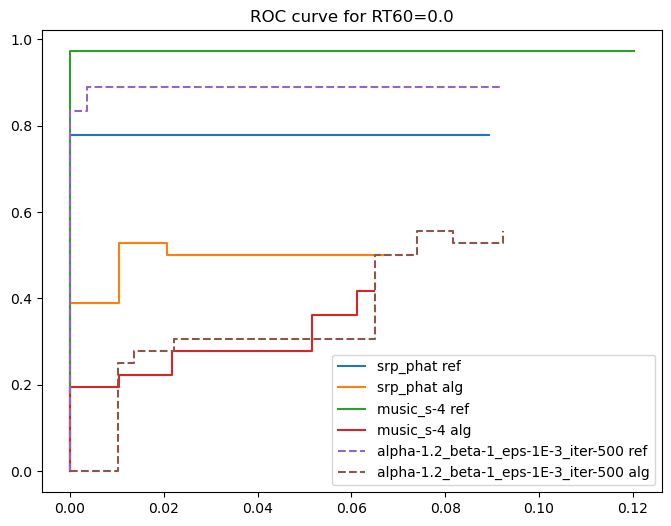

ZeroDivisionError: division by zero

In [154]:
thrs = np.sort(df_['thresholds_ang_spec'].unique())[::-1]
print(thrs)

for rt60 in df_results_thr['rt60'].unique():

    plt.figure(figsize=(8, 6))
    plt.title(f'ROC curve for RT60={rt60}')
    
    for method_id in unique_method_ids:

        tpr_list = []
        fpr_list = []
        
        for t, thr in enumerate(thrs):

            tpr_list_ = []
            fpr_list_ = []
            
            df_ = df_results_thr.loc[
                    (df_results_thr['method_id'] == method_id)
                    & (df_results_thr['rt60'] == rt60)
                ]
            
            loc_method = df_['loc_method'].unique()
            sv_method = df_['sv_method'].unique()
            assert len(sv_method) == 1
            sv_method = sv_method[0]
            assert len(loc_method) == 1
            loc_method = loc_method[0]
            
            frame_ids_ = df_['frame_id'].unique()
                        
            for frame_id in frame_ids_:

                df__ = df_[(df_['frame_id'] == frame_id)]
                print(len(df_), len(df__))
                    
                tpr = np.mean(df__[df__['thresholds_ang_spec'] == thr]['tpr'].values)
                fpr = np.mean(df__[df__['thresholds_ang_spec'] == thr]['fpr'].values)
                peaks_id = df__[df__['thresholds_ang_spec'] == thr]['peaks_ids'].values
                
                # check that tpr and fpr are not nans
                if np.isnan(tpr) or np.isnan(fpr):
                    print(frame_id)
                    print(peaks_id)
                    print(tpr)
                    print(fpr)
                    print(method_id)
                    print(df__)
                    raise ValueError('TPR or FPR is nan')
                
                assert len(np.unique(tpr)) == len(np.unique(fpr)) == 1
                            
                tpr_list_.append(tpr)
                fpr_list_.append(fpr)
            
            tpr_list.append(np.average(tpr_list_))
            fpr_list.append(np.average(fpr_list_))
            
        # plot ROC curve
        tpr_list = [0] + tpr_list
        fpr_list = [0] + fpr_list
        
        label = loc_method + ' ' + sv_method
        
        # compute AUC
        auc = np.trapezoid(tpr_list, fpr_list)
        print(f'AUC for {label} is {auc}')
        print('FPR', [f"{i:0.2f}" for i in fpr_list])
        print('TPR', [f"{i:0.2f}" for i in tpr_list])
        
        
        if 'alpha' in loc_method:
            plt.step(fpr_list, tpr_list, label=label, linestyle='--',where='post')
        else:
            plt.step(fpr_list, tpr_list, label=label,)
        
    plt.legend(loc='lower right')
    plt.show()
    1/0

In [156]:
for i in df_['frame_id'].unique():
    print(i)
    print(len(df_[df_['frame_id'] == i]))
    print(df__[df__['thresholds_ang_spec'] == thr]['tpr'].values)
    print('---')

nSrc-3_doas-[55 59 50]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.0_mc-8
84
[0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
 0.66666667 0.66666667 0.66666667]
---
nSrc-3_doas-[40 56 16]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.0_mc-9
87
[0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
 0.66666667 0.66666667 0.66666667]
---
nSrc-3_doas-[47  9 14]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.0_mc-2
123
[0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
 0.66666667 0.66666667 0.66666667]
---
nSrc-3_doas-[49 16  9]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.0_mc-3
96
[0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
 0.666

In [152]:
len(df_)

1059